<a href="https://colab.research.google.com/github/bugeki/ML_and_DL_Projects/blob/main/TUR_Food_Order_Custom_NER_roberta_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
%%capture
!pip install transformers

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import transformers
from transformers import RobertaTokenizerFast

from transformers import  RobertaForTokenClassification

from torch.optim import AdamW

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

In [ ]:
from torch.optim import Adam

# food order  data load

In [ ]:

# read the CoNLL file into a list of lines
with open('/content/siparisv3merged.txt', 'r') as f:
    lines = f.readlines()[1:]

# initialize an empty list to store the rows
rows = []

# initialize the sentence ID counter
sentence_id = 0

# iterate over the lines and split each line into fields
for line in lines:
    fields = line.strip().split()
    if fields:  # line is not empty
        rows.append([sentence_id] + fields)
    else:  # line is empty
        sentence_id += 1

# create a Pandas dataframe from the rows
df0 = pd.DataFrame(rows, columns=['sentence_id', 'words', 'col2', 'col3','labels'])


In [ ]:
df=df0[['sentence_id','words','labels']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40274 entries, 0 to 40273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  40274 non-null  int64 
 1   words        40274 non-null  object
 2   labels       40146 non-null  object
dtypes: int64(1), object(2)
memory usage: 944.0+ KB


In [ ]:
df = df.dropna()

In [ ]:
df

,sentence_id,words,labels
0,0,Pizza,B-yemek
1,0,istiyorum,O
2,0,yanında,O
3,0,orta,B-icecek_buyukluk
4,0,boy,O
...,...,...,...
40269,3734,istiyorum,O
40270,3734,kapıda,O
40271,3734,nakit,B-odeme
40272,3734,öderim,O


In [ ]:
unique_labels = df['labels'].str.split().explode().value_counts()
unique_labels

O                    21531
B-yemek               3708
B-adres               2870
B-odeme               2844
B-yemek_cesit         2333
I-odeme               1810
B-yemek_adet          1397
B-icecek               695
B-yemek_icerik         693
B-yemek_buyukluk       642
I-yemek                516
B-icecek_adet          307
I-yemek_buyukluk       282
I-yemek_icerik         175
B-icecek_buyukluk      109
I-yemek_cesit          107
B-icecek_icerik         47
I-adres                 32
I-icecek                30
I-yemek_adet            18
Name: labels, dtype: int64

In [ ]:
# Create a new dataframe with the sentence_id and words columns
df_new = df[['sentence_id', 'words']]

# Group the dataframe by sentence_id and join the words together
df_new = df_new.groupby('sentence_id').agg({'words': ' '.join}).reset_index()

# Rename the 'words' column to 'sentence'
df_new = df_new.rename(columns={'words': 'text'})

# Create a new column 'tags' by grouping the 'labels' column by 'sentence_id' and join them together
df_new['labels'] = df.groupby('sentence_id')['labels'].apply(lambda x: ' '.join(x)).reset_index(drop=True)

In [ ]:
df_new = df_new.drop(columns=["sentence_id"], axis=1)

In [ ]:
df=df_new

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3719 entries, 0 to 3718
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3719 non-null   object
 1   labels  3719 non-null   object
dtypes: object(2)
memory usage: 58.2+ KB


In [ ]:
df

,text,labels
0,Pizza istiyorum yanında orta boy kola olsun ev...,B-yemek O O B-icecek_buyukluk O B-icecek O B-a...
1,Sucuklu pizza istiyorum yanında küçük boy kola...,B-yemek_cesit B-yemek O O B-icecek_buyukluk O ...
2,bir tane sucuklu bir tane karışık pizza istiyo...,B-yemek_adet O B-yemek_cesit B-yemek_adet O B-...
3,Pizza istiyorum biri akdeniz ikincisi kavurmal...,B-yemek O B-yemek_adet B-yemek_cesit B-yemek_a...
4,İki tane pizza istiyorum biri Akdeniz diğeri k...,B-yemek_adet O B-yemek O B-yemek_adet B-yemek_...
...,...,...
3714,bize üç buçuk Pide istiyorum yanında şalgam ol...,O B-yemek_adet I-yemek_adet B-yemek O O B-icec...
3715,Bizim eve iki büyük pizza ve iki kola istiyoru...,O B-adres B-yemek_adet B-yemek_buyukluk B-yeme...
3716,Buraya eve iki orta hamburger ve üç orta ayran...,O B-adres B-yemek_adet B-yemek_buyukluk B-yeme...
3717,Benim iş yerine bir büyük koko ve bir sprite i...,O B-adres O B-yemek_adet B-yemek_buyukluk B-ye...


In [ ]:
# Split labels based on whitespace and turn them into a list
labels = [i.split() for i in df['labels'].values.tolist()]

In [ ]:
# Check how many labels are there in the dataset
unique_labels = set()

In [ ]:
for lb in labels:
  [unique_labels.add(i) for i in lb if i not in unique_labels]
 
print(unique_labels)

{'B-adres', 'I-yemek', 'O', 'I-icecek', 'B-yemek_cesit', 'B-icecek', 'I-yemek_icerik', 'B-icecek_icerik', 'I-adres', 'I-yemek_cesit', 'B-yemek_adet', 'B-odeme', 'B-yemek', 'B-yemek_icerik', 'I-odeme', 'B-icecek_adet', 'B-icecek_buyukluk', 'I-yemek_buyukluk', 'B-yemek_buyukluk', 'I-yemek_adet'}


In [ ]:
len(unique_labels)

20

In [ ]:
# Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}
print(labels_to_ids)

{'B-adres': 0, 'B-icecek': 1, 'B-icecek_adet': 2, 'B-icecek_buyukluk': 3, 'B-icecek_icerik': 4, 'B-odeme': 5, 'B-yemek': 6, 'B-yemek_adet': 7, 'B-yemek_buyukluk': 8, 'B-yemek_cesit': 9, 'B-yemek_icerik': 10, 'I-adres': 11, 'I-icecek': 12, 'I-odeme': 13, 'I-yemek': 14, 'I-yemek_adet': 15, 'I-yemek_buyukluk': 16, 'I-yemek_cesit': 17, 'I-yemek_icerik': 18, 'O': 19}


In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
df

,text,labels
0,pizza istiyorum yanında orta boy kola olsun ev...,B-yemek O O B-icecek_buyukluk O B-icecek O B-a...
1,sucuklu pizza istiyorum yanında küçük boy kola...,B-yemek_cesit B-yemek O O B-icecek_buyukluk O ...
2,bir tane sucuklu bir tane karışık pizza istiyo...,B-yemek_adet O B-yemek_cesit B-yemek_adet O B-...
3,pizza istiyorum biri akdeniz ikincisi kavurmal...,B-yemek O B-yemek_adet B-yemek_cesit B-yemek_a...
4,i̇ki tane pizza istiyorum biri akdeniz diğeri ...,B-yemek_adet O B-yemek O B-yemek_adet B-yemek_...
...,...,...
3714,bize üç buçuk pide istiyorum yanında şalgam ol...,O B-yemek_adet I-yemek_adet B-yemek O O B-icec...
3715,bizim eve iki büyük pizza ve iki kola istiyoru...,O B-adres B-yemek_adet B-yemek_buyukluk B-yeme...
3716,buraya eve iki orta hamburger ve üç orta ayran...,O B-adres B-yemek_adet B-yemek_buyukluk B-yeme...
3717,benim iş yerine bir büyük koko ve bir sprite i...,O B-adres O B-yemek_adet B-yemek_buyukluk B-ye...


#Tokenization 

In [ ]:
max_length = df['text'].apply(len).max()
print(max_length)

158


In [ ]:
# Let's take a look at how can we preprocess the text - Take first example
text = df['text'].values.tolist()
example = text[36]

print(example)


bana altı tane kokoreç hepsi sebzeli olacak altı tane de şalgam ver evime gelsin posla ödeme yapacağım


In [ ]:
from transformers import AutoModel, AutoTokenizer



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("burakaytan/roberta-base-turkish-uncased")
# 'roberta', 'burakaytan/roberta-base-turkish-uncased'
#tokenizer = BertTokenizerFast.from_pretrained('dbmdz/bert-base-turkish-uncased')
text_tokenized = tokenizer(example, padding='max_length', max_length=256, truncation=True, return_tensors="pt")


We provide several arguments when calling tokenizer method from BertTokenizerFast class above:

padding : to pad the sequence with a special [PAD] token to the maximum length that we specify. The maximum length of a sequence for a BERT model is 512.


max_length : maximum length of a sequence.

truncation : this is a Boolean value. If we set the value to True, then tokens that exceed the maximum length will not be used.

return_tensors : the tensor type that is returned, depending on machine learning frameworks that we use. Since we’re using PyTorch, then we use pt .

In [ ]:

print(text_tokenized)

{'input_ids': tensor([[    0,  5194,  3067,  3791,  2814,   307,   434,  4040, 10249,   571,
          1072,  3067,  3791,   336, 13109,  2983,   433, 27126, 10296, 13608,
           298,  3588, 13166,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

As you can see, the output that we get from the tokenization process is a dictionary, which contains three variables:

input_ids: The id representation of the tokens in a sequence. In BERT, the id 101 is reserved for the special [CLS] token, the id 102 is reserved for the special [SEP] token, and the id 0 is reserved for [PAD] token.
token_type_ids: To identify the sequence in which a token belongs to. Since we only have one sequence per text, then all the values of token_type_idswill be 0.
attention_mask : To identify whether a token is a real token or padding. The value would be 1 if it’s a real token, and 0 if it’s a [PAD] token.
From the input_ids above, we can decode the ids back into the original sequence with decode method as follows:

In [ ]:
print(tokenizer.decode(text_tokenized.input_ids[0]))


<s>bana altı tane kokoreç hepsi sebzeli olacak altı tane de şalgam ver evime gelsin posla ödeme yapacağım</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

We got our original sequence back after implementing decode method with the addition of special tokens from BERT such as [CLS] token at the beginning of the sequence, [SEP] token at the end of the sequence, and a bunch of [PAD] tokens to fulfill the required maximum length of 512.

After this tokenization process, we need to proceed to the next step, which is adjusting the label of each token.

Adjusting Label After Tokenization
This is a very important step that we need to do after the tokenization process. This is because the length of the sequence is no longer matching the length of the original label after the tokenization process.

The BERT tokenizer uses the so-called word-piece tokenizer under the hood, which is a sub-word tokenizer. This means that BERT tokenizer will likely to split one word into one or more meaningful sub-words.

The sequence above has in total 13 tokens and thus, it also has 13 labels. However, after BERT tokenization, we get the following result:



In [ ]:
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))


['<s>', 'bana', 'ĠaltÄ±', 'Ġtane', 'Ġkok', 'or', 'eÃ§', 'Ġhepsi', 'Ġsebz', 'eli', 'Ġolacak', 'ĠaltÄ±', 'Ġtane', 'Ġde', 'ĠÅŁal', 'gam', 'Ġver', 'Ġevime', 'Ġgelsin', 'Ġpos', 'la', 'ĠÃ¶deme', 'ĠyapacaÄŁÄ±m', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

There are two problems that we need to address after tokenization process:

The addition of special tokens from BERT such as [CLS], [SEP], and [PAD]
The fact that some tokens are splitted into sub-words.
As sub-word tokenization, word-piece tokenization splits uncommon words into their sub-words, such as ‘Geir’ and ‘Haarde’ in the example above. This sub-word tokenization helps the BERT model to learn the semantic meaning of related words.

The consequence of this word piece tokenization and the addition of special tokens from BERT is that the sequence length after tokenization is no longer matching the length of the initial label.

From the example above, now there are in total 512 tokens in the sequence after tokenization, while the length of the label is still the same as before. Also, the first token in a sequence is no longer the word ‘Prime’, but the newly added [CLS] token, so we need to shift our label as well.

To solve this problem, we need to adjust the label such that it has the same length as the sequence after tokenization. To do this, we can utilize the word_ids method from the tokenization result as follows:

In [ ]:
word_ids = text_tokenized.word_ids()
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))
print(word_ids)

['<s>', 'bana', 'ĠaltÄ±', 'Ġtane', 'Ġkok', 'or', 'eÃ§', 'Ġhepsi', 'Ġsebz', 'eli', 'Ġolacak', 'ĠaltÄ±', 'Ġtane', 'Ġde', 'ĠÅŁal', 'gam', 'Ġver', 'Ġevime', 'Ġgelsin', 'Ġpos', 'la', 'ĠÃ¶deme', 'ĠyapacaÄŁÄ±m', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

# after tokenize

As you can see from the code snippet above, each splitted token shares the same word_ids , where special tokens from BERT such as [CLS], [SEP], and [PAD] all do not have specificword_ids.

These word_ids will be very useful to adjust the length of the label by applying either of these two methods:

We only provide a label to the first sub-word of each splitted token. The continuation of the sub-word then will simply have ‘-100’ as a label. All tokens that don’t have word_ids will also be labeled with ‘-100’.
We provide the same label among all of the sub-words that belong to the same token. All tokens that don’t have word_ids will be labeled with ‘-100’.
The function in the code snippet below will do exactly the step defined above.

In [ ]:
def align_label_example(tokenized_input, labels):

        word_ids = tokenized_input.word_ids()

        previous_word_idx = None
        label_ids = []
   
        for word_idx in word_ids:

            if word_idx is None:
                label_ids.append(-100)
                
            elif word_idx != previous_word_idx:
                try:
                  label_ids.append(labels_to_ids[labels[word_idx]])   ## flaw
                except:
                  label_ids.append(-100)
        
            else:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
      

        return label_ids

#Unfortunately, 
there is a major flaw in align_label_example that causes the label predictions to be unstable. Line 15 "labels_to_ids[labels[word_idx]]" assumes that "word_idx" always represents the correct label index of the corresponding token. That assumption doesn't hold.
Example for "1. NAME OF PERSONS":
BERT Tokens:
['[CLS]', '1', '.', 'N', '##AM', '##E', 'OF', 'P', '##ER', '##SO', '##NS']
Word IDs:
[None, 0, 1, 2, 2, 2, 3, 4, 4, 4,4]
Splitting the sequence "1. NAME OF PERSONS" on whitespaces results in ['1.', 'NAME', 'OF', 'PERSONS'] where '1.' is one token, but BERT created two tokens.
If our labeled data would start at token "NAME", having the label index 1, the align_label_example function would incorrectly assign a label to "." (the dot behind "1").

If you want to apply the first method, set label_all_tokens to False. If you want to apply the second method, set label_all_tokens to True, as you can see in the following code snippet:

In [ ]:
label = labels[36]

#If we set label_all_tokens to True.....
label_all_tokens = False

new_label = align_label_example(text_tokenized, label)
print(new_label)
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))

[-100, 19, 7, 19, 6, -100, -100, 7, 10, -100, 19, 2, 19, 19, 1, -100, 19, 0, 19, 5, -100, 19, 19, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

In the rest of this article, we’re going to implement the first method, in which we will only provide a label to the first sub-word in each token and set label_all_tokens to False.



#Dataset Class
Before we train our BERT model for NER task, we need to create a dataset class to generate and fetch data in a batch.

In [ ]:

def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=256, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 256, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In the code snippet above, we call BertTokenizerFast class with tokenizer variable in the __init__ function to tokenize our input texts, and align_label function to adjust our label after tokenization process.

Next, let’s split our data randomly into training, vaidation, and test. However, mind you that the total number of data is 47959. Hence, for demonstration purpose and to speed up the training process, I’m going to take only 1000 of them. You can, of course, take all of the data for model training.

Next, let’s split our data randomly into training, vaidation, and test. 

In [ ]:
# df = df[0:1000]  first 1000 rows
df_train, df_val, df_test = np.split( df.sample( frac=1, random_state=42, ), 
                            [int(.8 * len(df)), int(.9 * len(df))])

#Model Building
In this article, we’re going to use a pretrained BERT base model from HuggingFace. Since we’re going to classify text in the token level, then we need to use BertForTokenClassification class.

BertForTokenClassification class is a model that wraps BERT model and adds linear layers on top of BERT model that will act as token-level classifiers.

In [ ]:
#model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased")

class RobertaModel(torch.nn.Module):

    def __init__(self):

        super(RobertaModel, self).__init__()

        self.roberta = RobertaForTokenClassification.from_pretrained("burakaytan/roberta-base-turkish-uncased", num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):

        output = self.roberta(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

In the code snippet above, first, we instantiate the model and set the output of each token classifier equal to the number of unique entities on our dataset, which in our case is 17.

Next, we will define a function for the training loop.

#Training Loop
The training loop for our BERT model is the standard PyTorch training loop with a few additions, as you can see below:

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []         ## added by me

def train_loop(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
       
        avg_train_loss = total_loss_train / len(df_train)   ## added by me
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)              # added by me
        
        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        # Store the loss value for plotting the learning curve.
        validation_loss_values.append(val_loss)              # added by me

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')
    
    
LEARNING_RATE = 3e-5
EPOCHS = 4
BATCH_SIZE = 4

model = RobertaModel()
train_loop(model, df_train, df_val)

100%|██████████| 744/744 [02:36<00:00,  4.74it/s]


Epochs: 1 | Loss:  0.889 | Accuracy:  0.790 | Val_Loss:  0.392 | Accuracy:  0.891


100%|██████████| 744/744 [02:33<00:00,  4.83it/s]


Epochs: 2 | Loss:  0.283 | Accuracy:  0.925 | Val_Loss:  0.186 | Accuracy:  0.946


100%|██████████| 744/744 [02:33<00:00,  4.84it/s]


Epochs: 3 | Loss:  0.184 | Accuracy:  0.948 | Val_Loss:  0.154 | Accuracy:  0.954


100%|██████████| 744/744 [02:33<00:00,  4.84it/s]


Epochs: 4 | Loss:  0.144 | Accuracy:  0.957 | Val_Loss:  0.127 | Accuracy:  0.961


In the training loop above, I only train the model for 5 epochs and then use SGD as the optimizer. The loss computation in each batch is already taken care of by BertForTokenClassification class.

In each epoch of the training loop, there is also an important step that we need to do. After model prediction, we need to ignore all of the tokens that have ‘-100’ as the label, as you can see in lines 36, 37, 62, and 63.

Below is the example of the training output after we train our BERT model for 5 epochs:

Of course, the output that you’ll see may vary when you train your own BERT model as there is stochasticity in the training process.

There are a lot of things that you can do to improve the performance of our model. If you notice, we have a data imbalance problem as there are a lot of tokens with ‘O’ label. We can improve our model, for example, by applying class weights during the training process.

Also, you can try different optimizers such as the Adam optimizer with weight decay regularization.

In [ ]:
stop here *1.modeli 

#alternate train

In [ ]:
LEARNING_RATE = 3e-5
EPOCHS = 5
BATCH_SIZE = 4

model = RobertaModel()


In [ ]:
early_stopping_patience = 3
early_stopping_delta = 0.01
best_validation_loss = float('inf')
epochs_since_improvement = 0
loss_values, validation_loss_values = [], []

def train_loop(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
       
    avg_train_loss = total_loss_train / len(df_train)
         # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    model.eval()

    total_acc_val = 0
    total_loss_val = 0

    for val_data, val_label in val_dataloader:

          val_label = val_label.to(device)
          mask = val_data['attention_mask'].squeeze(1).to(device)
          input_id = val_data['input_ids'].squeeze(1).to(device)

          with torch.no_grad():
            loss, logits = model(input_id, mask, val_label)

          for i in range(logits.shape[0]):

            logits_clean = logits[i][val_label[i] != -100]
            label_clean = val_label[i][val_label[i] != -100]

            predictions = logits_clean.argmax(dim=1)
            acc = (predictions == label_clean).float().mean()
            total_acc_val += acc
            total_loss_val += loss.item()

    val_accuracy = total_acc_val / len(df_val)
    val_loss = total_loss_val / len(df_val)

         # Store the loss value for plotting the learning curve.
    validation_loss_values.append(val_loss)

    print(
            f'Epochs: {epoch_num + 1} | Loss: {avg_train_loss:.3f} | Accuracy: {total_acc_train / len(df_train):.3f} | Val_Loss: {val_loss:.3f} | Accuracy: {total_acc_val / len(df_val):.3f}')

         # Check if this is the best model based on validation loss
    best_loss= 1
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

         # Check if this is the best model based on validation accuracy
    best_acc= 1
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        torch.save(model.state_dict(), 'best_model.pt')

   # Return the loss and validation loss values after training
    return loss_values, validation_loss_values

In [ ]:
train_loop(model, df_train, df_val)

#Evaluate Model on Test Data
Now that we have trained our model, we can evaluate its performance on unseen test data with the following code snippet.

In [ ]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)

    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.959


# macro eval

You can use the scikit-learn library's f1_score function and its classification_report function to compute the F1-score and the macro average F1-score, respectively. First, you need to change the loop that computes the predictions to store them in a list of arrays, one array per batch. Then, you can use the f1_score and classification_report functions on the concatenated list of arrays to compute the F1-score and macro average F1-score.

Here's a modification of the function that includes these computations:

In [ ]:
from sklearn.metrics import f1_score, classification_report

def evaluate(model, df_test):
    test_dataset = DataSequence(df_test)
    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    y_true = []
    y_pred = []
    for test_data, test_label in test_dataloader:
        test_label = test_label.to(device)
        mask = test_data['attention_mask'].squeeze(1).to(device)
        input_id = test_data['input_ids'].squeeze(1).to(device)

        loss, logits = model(input_id, mask, test_label)
        for i in range(logits.shape[0]):
            logits_clean = logits[i][test_label[i] != -100]
            label_clean = test_label[i][test_label[i] != -100].tolist()

            predictions = logits_clean.argmax(dim=1).tolist()
            y_true.extend(label_clean)
            y_pred.extend(predictions)

    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f'Macro F1-score: {f1_macro:.3f}')
    print(classification_report(y_true, y_pred))

In [ ]:
evaluate(model, df_test)

Macro F1-score: 0.777
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       281
           1       0.97      1.00      0.99        72
           2       0.90      0.97      0.93        29
           3       1.00      0.91      0.95        11
           4       0.83      1.00      0.91         5
           5       0.99      0.99      0.99       273
           6       0.89      0.93      0.91       367
           7       0.97      0.98      0.98       147
           8       0.96      0.91      0.93        77
           9       0.86      0.86      0.86       239
          10       0.77      0.70      0.73        73
          11       0.50      0.33      0.40         3
          12       0.00      0.00      0.00         1
          13       0.99      0.99      0.99       182
          14       0.66      0.80      0.72        54
          15       0.00      0.00      0.00         1
          16       0.57      0.86      0.69        28
     

Note that in this modification, the loop that computes the accuracy has been removed, since accuracy is not directly related to F1-score

In [ ]:
labels_to_ids

{'B-adres': 0,
 'B-icecek': 1,
 'B-icecek_adet': 2,
 'B-icecek_buyukluk': 3,
 'B-icecek_icerik': 4,
 'B-odeme': 5,
 'B-yemek': 6,
 'B-yemek_adet': 7,
 'B-yemek_buyukluk': 8,
 'B-yemek_cesit': 9,
 'B-yemek_icerik': 10,
 'I-adres': 11,
 'I-icecek': 12,
 'I-odeme': 13,
 'I-yemek': 14,
 'I-yemek_adet': 15,
 'I-yemek_buyukluk': 16,
 'I-yemek_cesit': 17,
 'I-yemek_icerik': 18,
 'O': 19}

In my case, the trained model achieved an average of 92,22% accuracy on the test set. You can of course, change the metrics to F1 score, precision, or recall.

Alternatively, we can use the trained model to predict the entity of each word of a text or a sentence with the following code:

# inference test

In [ ]:
def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=256, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def evaluate_one_text(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 256, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    #print(sentence)
    #print(prediction_label)
    ###
    sentence = sentence.split()
    current_item = None
    item_list = []

    for i, tag in enumerate(prediction_label):
        if tag.startswith("B-"):
            current_item = tag[2:]
            item_list.append((current_item, sentence[i]))
        elif tag.startswith("I-"):
            item_list.append((current_item, sentence[i]))

    print(item_list)        


In [ ]:
evaluate_one_text(model, 'büyük pizza gönder soğansız olsun yanında light kola eve yolla kartla öderim')

[('yemek_buyukluk', 'büyük'), ('yemek', 'pizza'), ('yemek_icerik', 'soğansız'), ('icecek_icerik', 'light'), ('icecek', 'kola'), ('adres', 'eve'), ('odeme', 'kartla')]


#graph

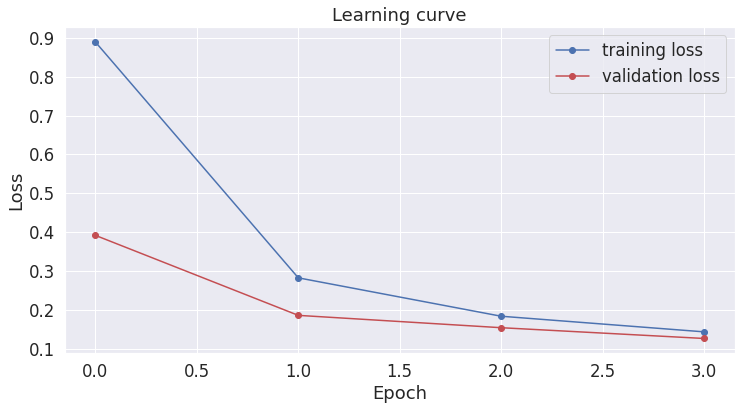

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# save and load

To save a finetuned PyTorch model as the files you listed, you can use the save_pretrained method provided by the Hugging Face Transformers library. Here's an example:

This will save the trained model and tokenizer in the specified output directory as the following files:

config.json: The model configuration file.
eval_results.txt: The evaluation results file (only present if you use the Trainer class for training and validation).
merges.txt: The BPE merges file (only present for BPE-based tokenizers).
model_args.json: The model arguments file (only present if you use the TrainingArguments class to define your training arguments).
pytorch_model.bin: The PyTorch model file.
special_tokens_map.json: The special tokens map file.
tokenizer.json: The tokenizer file (only present for legacy tokenizers).
tokenizer_config.json: The tokenizer configuration file.
training_args.bin: The training arguments file (only present if you use the TrainingArguments class to define your training arguments).
vocab.json: The vocabulary file (only present for non-BPE-based tokenizers).
Note that some of these files may not be present depending on the type of tokenizer and training configuration used. Also, if you used the Trainer class for training and validation, you may have additional files in the output directory such as training_results.txt and training_stats.json.

# class index için

In [ ]:
print(dir(TrainingArguments))

#ONNX

Export with transformers.onnx (mid-level)
transformers.onnx enables you to convert model checkpoints to an ONNX graph by leveraging configuration objects. That way you don’t have to provide the complex configuration for dynamic_axes etc.

You’ll first need to install some dependencies:

In [ ]:
pip install transformers[onnx] torch


Exporting our checkpoint with the transformers.onnx.



In [ ]:
from pathlib import Path
import transformers
from transformers.onnx import FeaturesManager
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

# load model and tokenizer
model_id = "/content/drive/MyDrive/NLP"
feature = "token-classification"
model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load config
model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(model, feature=feature)
onnx_config = model_onnx_config(model.config)

# export
onnx_inputs, onnx_outputs = transformers.onnx.export(
        preprocessor=tokenizer,
        model=model,
        config=onnx_config,
        opset=13,
        output=Path("robertaturk-model.onnx")
)


#save

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/'#drive/MyDrive/NLP/robertatorch'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
#model_to_save.save_pretrained(output_dir)
torch.save(model.state_dict(), "fine_tuned_roberta.pt")  # yukardaki çalışmadı bununla alttakini kaydettim
torch.save(model.state_dict(), "model.bin")
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))  # çalışmadı args not defined

Saving model to /content/


('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.json',
 '/content/merges.txt',
 '/content/added_tokens.json',
 '/content/tokenizer.json')

In [ ]:
print(dir(model.modules))

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [ ]:
model.modules

In [ ]:
!ls -l --block-size=K /content/    ## size of the files

total 974256K
drwx------ 5 root root      4K Mar 16 05:26 drive
-rw-r--r-- 1 root root 484740K Mar 16 05:48 fine_tuned_roberta.pt
-rw-r--r-- 1 root root    620K Mar 16 05:49 merges.txt
-rw-r--r-- 1 root root 484725K Mar 16 05:56 model.bin
drwxr-xr-x 2 root root      4K Mar 16 05:44 robertatorch
drwxr-xr-x 1 root root      4K Mar 14 13:35 sample_data
-rw-r--r-- 1 root root    778K Mar 16 05:25 siparisv3merged.txt
-rw-r--r-- 1 root root      1K Mar 16 05:49 special_tokens_map.json
-rw-r--r-- 1 root root      2K Mar 16 05:49 tokenizer_config.json
-rw-r--r-- 1 root root   2406K Mar 16 05:49 tokenizer.json
-rw-r--r-- 1 root root    953K Mar 16 05:49 vocab.json


#save to drive

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r /content/robertatorch "/content/drive/MyDrive/NLP/robertatorch"

# load 

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

NameError: ignored

In [ ]:
from transformers import RobertaForTokenClassification

model = RobertaForTokenClassification.from_pretrained("/content/drive/MyDrive/NLP/robertatorch")



OSError: ignored

#load

In [ ]:
pip install onnxruntime

In [ ]:
import torch
from transformers import RobertaForTokenClassification

# Load the saved state dictionary
state_dict = torch.load("/content/drive/MyDrive/NLP/fine_tuned_roberta.pt",map_location=torch.device('cpu'))

# Initialize a new RoBERTa model with the saved state dictionary
model = RobertaForTokenClassification.from_pretrained("burakaytan/roberta-base-turkish-uncased", state_dict=state_dict)

# Prepare an example input tensor (e.g., a tensor of zeros with the appropriate shape)
example_input = torch.zeros((1, 256), dtype=torch.long)

# Trace the PyTorch model using the example input tensor to generate an ONNX model representation
torch.onnx.export(model, example_input, "fine_tuned_roberta.onnx")


In [ ]:
import onnxruntime as ort


In [ ]:
from transformers import RobertaTokenizer


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('/content/drive/MyDrive/NLP') 

In [ ]:
# Step 5: Load the ONNX model using onnxruntime
session = ort.InferenceSession("fine_tuned_roberta.onnx")

# Step 6: Preprocess the input data for inference
input_data = "Example input text"
input_ids = tokenizer.encode(input_data, add_special_tokens=True)
input_tensor = torch.tensor(input_ids).unsqueeze(0)

# Step 7: Run inference on the ONNX model using the preprocessed input data
output = session.run(None, {"input_ids": input_tensor.numpy()})

# Step 8: Post-process the output to get the final predictions
predicted_labels = np.argmax(output[0], axis=2).flatten().tolist()
predicted_tokens = tokenizer.convert_ids_to_tokens(input_ids)
predicted_entities = get_entities_from_labels(predicted_labels, predicted_tokens)

#push to hugging face

In [ ]:
pip install huggingface_hub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub("robertatorch")
tokenizer.push_to_hub("robertatorch")

AttributeError: ignored

In [ ]:
# Save the model's weights
torch.save(model.state_dict(), "/content/weights.pth")

In [ ]:
torch.save(model, '/content/weights.pt')

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), "model_state_dict.bin")

In [ ]:

# Save the optimizer's state_dict
#torch.save(optimizer.state_dict(), "optimizer_state_dict.bin")

# Save the training configuration
training_config = {"num_epochs": EPOCHS, "learning_rate": LEARNING_RATE}
torch.save(training_config, "training_config.json")


In [ ]:
tokenizer.save_vocabulary('/content/')


In [ ]:
torch.save(model.state_dict(), "pytorch_model.bin")

In [ ]:
from transformers import RobertaConfig

# Assume that you have trained your RoBERTa model and it is stored in the 'model' variable
# Get the configuration of the trained model
config = model.config

# Save the configuration to a file
with open("fine_tuned_roberta_config.json", "w") as fp:
    fp.write(config.to_json_string())



In [ ]:
model=torch.load("C:\Users\Bug\Downloads\turktorchmodel2.pt", map_location=torch.device('cpu'))


load model.pt and convert to transformers model

In [ ]:

# Load the PyTorch model
model = torch.load("/content/drive/MyDrive/NLP/torcheng/turktorchmodel2.pt")

# Save the model's architecture
config = model.config
config.to_json_file("/content/config.json")

# Save the model's weights
torch.save(model.state_dict(), "/content/weights.pt")




In [ ]:
# Create a Hugging Face model
model_class, tokenizer_class = transformers.BertModel, transformers.BertTokenizer
model = model_class.from_pretrained("/content/weights.pt", config=config)
tokenizer = tokenizer_class.from_pretrained("/content/")

#save and load 2 

This code snippet assumes that you have already trained and saved your custom NER RoBERTa model as a PyTorch state dictionary (.pth) file. The code loads the model and tokenizer using the Transformers library, prepares input data by tokenizing the input text, generates predictions using the model, and processes the output to obtain the predicted labels for the named entities in the input text.

In [ ]:
import torch
from transformers import RobertaForTokenClassification, RobertaTokenizer

# Load the RoBERTa model and tokenizer
model_path = 'custom_ner_roberta_model.pth'
model = RobertaForTokenClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Prepare input data
text = 'Example text for named entity recognition.'
input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)

# Generate predictions
with torch.no_grad():
    output = model(input_ids)

# Process output
predictions = torch.argmax(output[0], dim=2)[0]
labels = [tokenizer.decode([id]) for id in predictions]

print(labels)


To convert your custom NER RoBERTa model from PyTorch to ##ONNX format, you can follow these steps:

Install the ONNX package: You can install the ONNX package by running pip install onnx.

Convert the PyTorch model to ONNX format: You can use the torch.onnx.export() method to convert the PyTorch model to ONNX format. Here's an example code snippet:

In [ ]:
import torch.onnx

# Load the PyTorch model
model_path = 'custom_ner_roberta_model.pth'
model = RobertaForTokenClassification.from_pretrained(model_path)

# Prepare example input
text = 'Example text for named entity recognition.'
input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)

# Export the model to ONNX format
torch.onnx.export(model,                 # PyTorch model
                  input_ids,             # Example input
                  'custom_ner_roberta_model.onnx',   # Output file name
                  input_names=['input'], # Input names
                  output_names=['output'], # Output names
                  dynamic_axes={'input': {0: 'batch_size'}, # Dynamic axes
                                'output': {0: 'batch_size'}})


Once you have converted your custom NER RoBERTa model to ONNX format, you can use it for inference by following these steps:

Load the ONNX model: You can use the onnxruntime.InferenceSession class to load the ONNX model. Here's an example code snippet:

In [ ]:
import onnxruntime as ort

# Load the ONNX model
model_path = 'custom_ner_roberta_model.onnx'
session = ort.InferenceSession(model_path)


Prepare input data: To make predictions with the ONNX model, you need to prepare your input data in the format expected by the model. In this case, you need to tokenize your input text and convert it to a tensor of shape (batch_size, sequence_length).

In [ ]:
import numpy as np

# Tokenize the input text
text = 'Example text for named entity recognition.'
input_ids = tokenizer.encode(text, add_special_tokens=True)

# Convert the tokenized input to a tensor
input_ids = np.array(input_ids, dtype=np.int64).reshape(1, -1)


Generate predictions: Once you have prepared your input data, you can use the ONNX model to generate predictions using the session.run() method.

In [ ]:
# Generate predictions
outputs = session.run(None, {'input': input_ids})

# Process output
predictions = np.argmax(outputs[0], axis=2)[0]
labels = [tokenizer.decode([id]) for id in predictions]

print(labels)


n this code snippet, we use the session.run() method to generate predictions. We pass in the input data as a dictionary with the input name ('input') as the key and the input tensor as the value. The session.run() method returns a tuple of outputs, and in this case we are only interested in the first output. Finally, we process the output to obtain the predicted labels for the named entities in the input text.